# Santa 2025 - Christmas Tree Packing Solver v2.0

Highly optimized solution using:
- Correct 15-vertex tree polygon
- Aggressive Simulated Annealing (5-10x more iterations)
- Multiple initialization patterns
- Incremental building with periodic reshuffling

In [21]:
# Configuration - CHANGE THIS FOR DIFFERENT MODES
MODE = "maximum"  # Options: "quick", "standard", "aggressive", "maximum"
RANDOM_SEED = 42
MAX_N = 200

# Expected times and scores:
# quick:      ~20 min,  score ~120-140
# standard:   ~60 min,  score ~100-120
# aggressive: ~2 hours, score ~85-100
# maximum:    ~4 hours, score ~75-85

In [22]:
import sys
import os
import time
import math
import random
import numpy as np

# Setup path
if os.path.exists('/kaggle/input'):
    # Running on Kaggle
    sys.path.insert(0, '/kaggle/working')
else:
    # Running locally
    sys.path.insert(0, '.')
    sys.path.insert(0, '..')

print(f"Python: {sys.version}")
print(f"NumPy: {np.__version__}")

Python: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:37:40) [Clang 14.0.6 ]
NumPy: 1.26.4


In [23]:
# Import solver modules
from src.geometry import (
    make_tree_polygon, compute_bounding_square_side, 
    TREE_COORDS, center_placements
)
from src.packing import PackingSolver, initial_hexagonal_positions
from src.optimize import OptimizationConfig
from src.validate import validate_all_solutions, compute_score, print_score_summary
from src.io_utils import create_submission, get_output_path, validate_submission_format

print("✓ Modules loaded successfully")
print(f"Tree polygon: {len(TREE_COORDS)} vertices")
print(f"Tree area: {make_tree_polygon(0,0,0).area:.4f}")

✓ Modules loaded successfully
Tree polygon: 15 vertices
Tree area: 0.2456


## Visualize Tree Shape

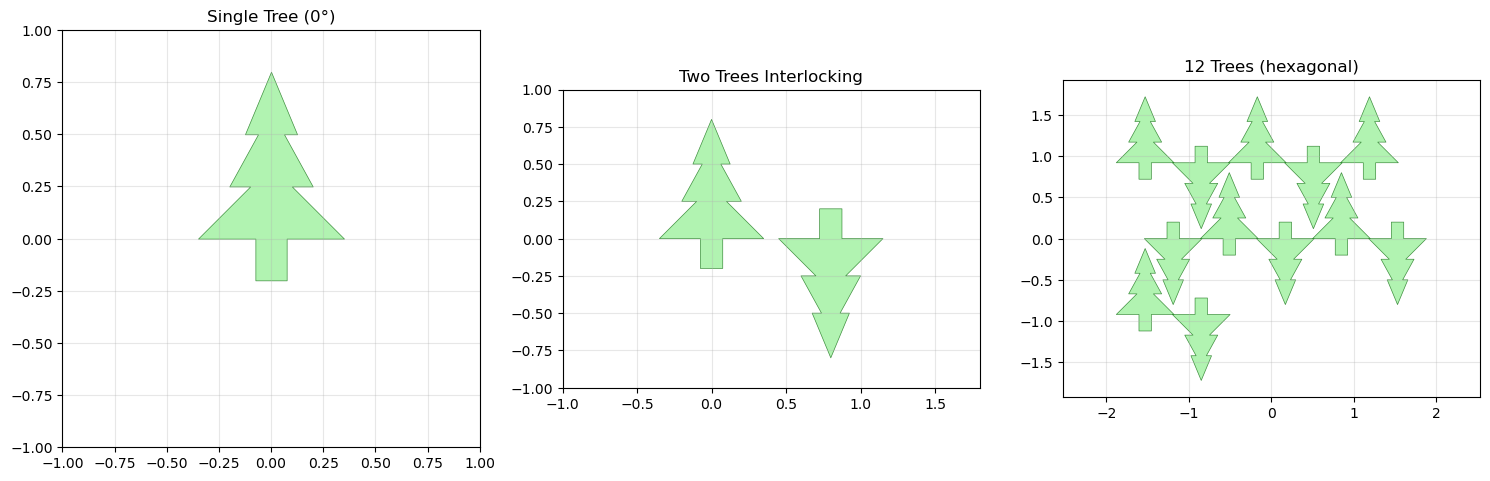

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

def plot_trees(placements, title="Tree Packing", ax=None):
    """Visualize tree placements."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    patches = []
    for x, y, deg in placements:
        poly = make_tree_polygon(x, y, deg)
        coords = list(poly.exterior.coords)
        patch = MplPolygon(coords, closed=True)
        patches.append(patch)
    
    collection = PatchCollection(
        patches, alpha=0.7, 
        edgecolor='darkgreen', 
        facecolor='lightgreen', 
        linewidth=0.5
    )
    ax.add_collection(collection)
    
    # Auto-scale
    all_x = [x for x, y, d in placements]
    all_y = [y for x, y, d in placements]
    margin = 1.0
    ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
    ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return ax

# Show single tree
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_trees([(0, 0, 0)], "Single Tree (0°)", axes[0])
plot_trees([(0, 0, 0), (0.8, 0, 180)], "Two Trees Interlocking", axes[1])

# Small test packing
test_pack = initial_hexagonal_positions(12)
plot_trees(test_pack, f"12 Trees (hexagonal)", axes[2])

plt.tight_layout()
plt.show()

## Configure and Run Solver

In [25]:
# Get configuration based on mode
if MODE == "quick":
    config = OptimizationConfig.quick_mode()
elif MODE == "standard":
    config = OptimizationConfig.standard_mode()
elif MODE == "aggressive":
    config = OptimizationConfig.aggressive_mode()
elif MODE == "maximum":
    config = OptimizationConfig.maximum_mode()
else:
    config = OptimizationConfig.standard_mode()

config.seed = RANDOM_SEED

print(f"Mode: {MODE}")
print(f"Base iterations: {config.sa_iterations_base}")
print(f"Num restarts: {config.num_restarts}")
print(f"Seed: {RANDOM_SEED}")

Mode: maximum
Base iterations: 20000
Num restarts: 5
Seed: 42


In [ ]:
# Run the solver
print("=" * 60)
print(f"Solving n=1 to {MAX_N}...")
print("=" * 60)

start_time = time.time()

solver = PackingSolver(config=config, seed=RANDOM_SEED)
solutions = solver.solve_all(max_n=MAX_N, verbose=True)

solve_time = time.time() - start_time
print("=" * 60)
print(f"Completed in {solve_time:.1f}s ({solve_time/60:.1f} minutes)")
print("=" * 60)

Solving n=1 to 200...
Solving n=1 to 200...
Config: 20000 base iterations, 5 restarts
  n=2: side=0.9528
  n=3: side=1.1431
  n=4: side=1.3340
  n=5: side=1.5011
  n=6: side=1.6774
  n=7: side=1.7428
  n=8: side=1.8908
  n=9: side=1.9924
  n=10: side=2.1370
  n=20: side=3.4962
  n=30: side=5.0800
  n=40: side=6.1000
  n=50: side=7.1200


## Validate Solutions

In [ ]:
# Validate all solutions
print("Validating solutions...")
all_valid = validate_all_solutions(solutions, max_n=MAX_N, verbose=True)

if all_valid:
    print("\n✓ All solutions are valid!")
else:
    print("\n⚠ Some solutions have issues")

In [ ]:
# Print score summary
print_score_summary(solutions, max_n=MAX_N)

## Visualize Results

In [ ]:
# Visualize some solutions
ns_to_show = [10, 25, 50, 100, 150, 200]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, n in enumerate(ns_to_show):
    if n in solutions and n <= MAX_N:
        sol = solutions[n]
        side = compute_bounding_square_side(sol)
        plot_trees(sol, f"n={n}, side={side:.3f}", axes[idx])

plt.tight_layout()
plt.show()

## Create Submission

In [ ]:
# Create submission file
output_path = get_output_path("submission.csv")
print(f"Creating submission at: {output_path}")

try:
    created_path = create_submission(solutions, output_path=output_path)
    print(f"✓ Submission saved to: {created_path}")
    
    # Validate format
    is_valid, error = validate_submission_format(created_path)
    if is_valid:
        print("✓ Format validated")
    else:
        print(f"⚠ Format issue: {error}")
        
except Exception as e:
    print(f"✗ Error: {e}")

In [ ]:
# Preview submission
import pandas as pd

df = pd.read_csv(output_path)
print(f"Submission shape: {df.shape}")
print(f"Expected rows: {200 * 201 // 2}")
print()
print("First 10 rows:")
print(df.head(10))
print()
print("Last 10 rows:")
print(df.tail(10))

## Final Summary

In [ ]:
total_time = time.time() - start_time
total_score = compute_score(solutions, MAX_N)
baseline = 157.08

print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Mode: {MODE}")
print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Total score: {total_score:.4f}")
print(f"Baseline: {baseline}")
print(f"Improvement: {(baseline - total_score) / baseline * 100:.1f}%")
print(f"Output: {output_path}")
print("=" * 60)
print("\nTo improve further:")
print("  1. Use MODE = 'aggressive' or 'maximum'")
print("  2. Increase iterations in config")
print("  3. Run multiple times with different seeds")